## 数据处理

In [106]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [107]:
%matplotlib inline

In [108]:
# 关于广告曝光次数的信息
ab_test_imp = pd.read_csv('data/section5-ab_test_imp.csv')

In [109]:
# 关于广告点击次数的信息
ab_test_goal = pd.read_csv('data/section5-ab_test_goal.csv')

In [110]:
ab_test_imp.head(2)

,log_date,app_name,test_name,test_case,user_id,transaction_id
0,2013-10-01,game-01,sales_test,B,36703,25622
1,2013-10-01,game-01,sales_test,A,44339,25623


In [111]:
ab_test_goal.head(2)

,log_date,app_name,test_name,test_case,user_id,transaction_id
0,2013-10-01,game-01,sales_test,B,15021,25638
1,2013-10-01,game-01,sales_test,B,351,25704


In [112]:
# 合并两份数据源
ab_test_imp = pd.merge(ab_test_imp, ab_test_goal, how='left', on='transaction_id', suffixes=('', '_g'))

In [113]:
ab_test_imp.head(2)

,log_date,app_name,test_name,test_case,user_id,transaction_id,log_date_g,app_name_g,test_name_g,test_case_g,user_id_g
0,2013-10-01,game-01,sales_test,B,36703,25622,NaN,NaN,NaN,NaN,NaN
1,2013-10-01,game-01,sales_test,A,44339,25623,NaN,NaN,NaN,NaN,NaN


In [114]:
# 增加点击标志
ab_test_imp['is_goal'] = np.where(ab_test_imp['user_id_g'].isnull(), 0, 1)

In [115]:
ab_test_imp['is_goal'].unique()

array([0, 1], dtype=int64)

## 数据分析

In [116]:
# 计算点击率
ab_test_imp.groupby('test_case').apply(lambda x: x['is_goal'].sum() / len(x))

test_case
A    0.080256
B    0.115460
dtype: float64

In [117]:
from scipy.stats import chisquare, chi2_contingency

In [118]:
cross_table = pd.crosstab(ab_test_imp['test_case'], ab_test_imp['is_goal'])

In [119]:
cross_table

is_goal,0,1
test_case,,
A,40592,3542
B,38734,5056


In [120]:
# 进行卡方检验
chi2_contingency(np.array([cross_table.iloc[0].values, cross_table.iloc[1].values]))

(308.37505289322877,
 4.934139633785632e-69,
 1,
 array([[39818.18029207,  4315.81970793],
        [39507.81970793,  4282.18029207]]))

In [121]:
def cvr_value(x):
    return sum(x) / len(x)

In [122]:
# 计算每天每个测试用例的点击率
ab_test_imp_summary = ab_test_imp.groupby(['log_date', 'test_case']).agg({'user_id': len, 'is_goal': [sum, cvr_value]})
ab_test_imp_summary.columns = ['imp', 'cv', 'cvr']
ab_test_imp_summary = ab_test_imp_summary.reset_index()

In [123]:
ab_test_imp_summary.head()

,log_date,test_case,imp,cv,cvr
0,2013-10-01,A,1358,98,0.072165
1,2013-10-01,B,1391,176,0.126528
2,2013-10-02,A,1370,88,0.064234
3,2013-10-02,B,1333,212,0.159040
4,2013-10-03,A,1213,170,0.140148


In [124]:
# 算出每个测试用例的点击率
cvr_avg = ab_test_imp_summary.groupby(['test_case']).apply(lambda x: sum(x['cv']) / sum(x['imp'])).to_frame(name='cvr_avg')
cvr_avg = cvr_avg.reset_index()

In [125]:
cvr_avg.head()

,test_case,cvr_avg
0,A,0.080256
1,B,0.115460


In [126]:
ab_test_imp_summary = pd.merge(ab_test_imp_summary, cvr_avg, on=['test_case'])

In [127]:
ab_test_imp_summary.head()

,log_date,test_case,imp,cv,cvr,cvr_avg
0,2013-10-01,A,1358,98,0.072165,0.080256
1,2013-10-02,A,1370,88,0.064234,0.080256
2,2013-10-03,A,1213,170,0.140148,0.080256
3,2013-10-04,A,1521,89,0.058514,0.080256
4,2013-10-05,A,1587,56,0.035287,0.080256


In [128]:
ab_test_imp_summary['log_date'] = pd.to_datetime(ab_test_imp_summary['log_date'])

In [129]:
import matplotlib.dates as mdates

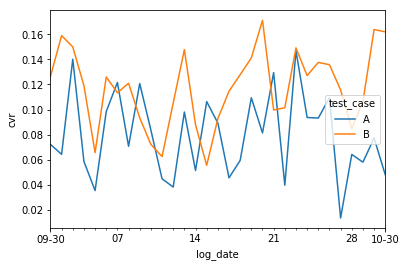

In [130]:
# 绘制不同测试用例的点击率时序图
fig, ax = plt.subplots()

pd.pivot_table(ab_test_imp_summary, index='log_date', columns='test_case', values='cvr').plot(ax=ax)
plt.ylabel('cvr')
plt.legend(title='test_case', loc='center right')

ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))

plt.show()